# 1- Feature Importance – Which Bands Detect Water Best?

# 1 – Load the Data

In [14]:
# import libraries 
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin



import sys
import os
sys.path.append(os.path.abspath('..'))
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
X =np.load('../data/processed/images_all_bands_data.npy')
Y =np.load('../data/processed/mask_all_bands_data.npy')
X.shape , Y.shape


((306, 128, 128, 12), (306, 128, 128, 1))

# 2 – Visualize a Sample
- Displayed one image band and its mask to check image quality.


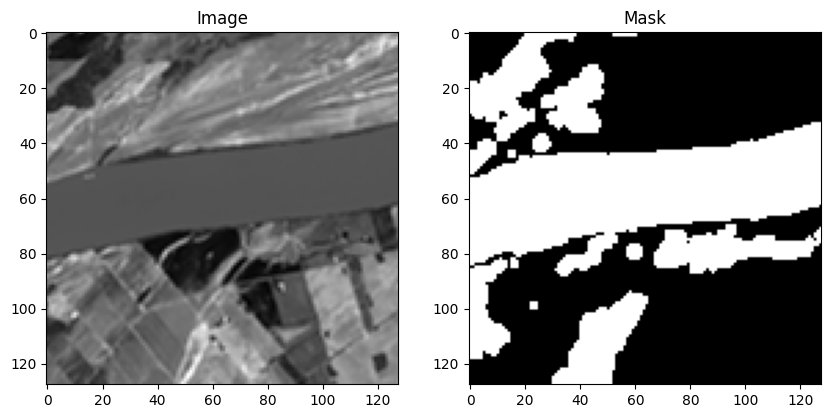

In [3]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X[100][:, :,3], cmap='gray')
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(Y[100], cmap='gray')
plt.title('Mask')
plt.show()

In [4]:
# Flatten the image bands 
flat_image = X.reshape(-1, 12) 

# Flatten the mask 
flat_mask = Y.reshape(-1) 

# Create DataFrame
df = pd.DataFrame(flat_image, columns=[f'Band_{i+1}' for i in range(12)])
df['Target'] = flat_mask

# Check
print(df.head())
print(df['Target'].value_counts())


     Band_1    Band_2    Band_3    Band_4    Band_5    Band_6    Band_7  \
0  0.225869  0.086957  0.068120  0.055598  0.063705  0.054846  0.034806   
1  0.247104  0.078947  0.069028  0.053282  0.061879  0.066826  0.038487   
2  0.247104  0.089245  0.081744  0.067181  0.123352  0.112087  0.066600   
3  0.202703  0.154462  0.248865  0.181467  0.384459  0.299255  0.178715   
4  0.202703  0.162471  0.265213  0.195367  0.431528  0.320021  0.186412   

   Band_8    Band_9   Band_10  Band_11  Band_12  Target  
0     0.0  0.653333  0.620690    0.875      0.0     0.0  
1     0.0  0.648889  0.620690    0.875      0.0     1.0  
2     0.0  0.653333  0.625000    0.250      0.0     1.0  
3     0.0  0.653333  0.629310    0.250      0.0     0.0  
4     0.0  0.657778  0.633621    0.250      0.0     0.0  
Target
0.0    3711232
1.0    1302272
Name: count, dtype: int64


In [5]:
df.shape

(5013504, 13)

In [6]:
df_sample = df.sample(n=100000, random_state=42)


In [ ]:
print(df_sample.head())
print(df_sample['Target'].value_counts())

           Band_1    Band_2    Band_3    Band_4    Band_5    Band_6    Band_7  \
3272434  0.171465  0.126995  0.169193  0.130690  0.571951  0.373095  0.264915   
3817006  0.372294  0.345960  0.393536  0.316092  0.275956  0.557178  0.303540   
4470713  0.205405  0.142422  0.225729  0.292216  0.081155  0.014214  0.007570   
4061682  0.643766  0.659193  0.713333  0.639274  0.414153  0.686017  0.651667   
3771972  0.363462  0.276803  0.361298  0.346824  0.569613  0.577684  0.492343   

         Band_8    Band_9   Band_10   Band_11  Band_12  Target  
3272434    0.40  0.321429  0.295455  0.375000  0.00000     0.0  
3817006    0.00  0.373134  0.382353  0.500000  0.00000     0.0  
4470713    0.25  0.034483  0.017241  0.875000  0.96875     1.0  
4061682    0.00  0.689655  0.823129  1.000000  0.00000     0.0  
3771972    0.00  0.757576  0.666667  0.285714  0.00000     0.0  
Target
0.0    73986
1.0    26014
Name: count, dtype: int64


 ## Correlation with the Target

Band_12    0.572573
Band_11    0.339334
Band_8     0.235948
Band_4    -0.066669
Band_3    -0.114165
Band_2    -0.173047
Band_1    -0.180641
Band_9    -0.443495
Band_10   -0.448656
Band_7    -0.474673
Band_6    -0.562078
Band_5    -0.562502
Name: Target, dtype: float64


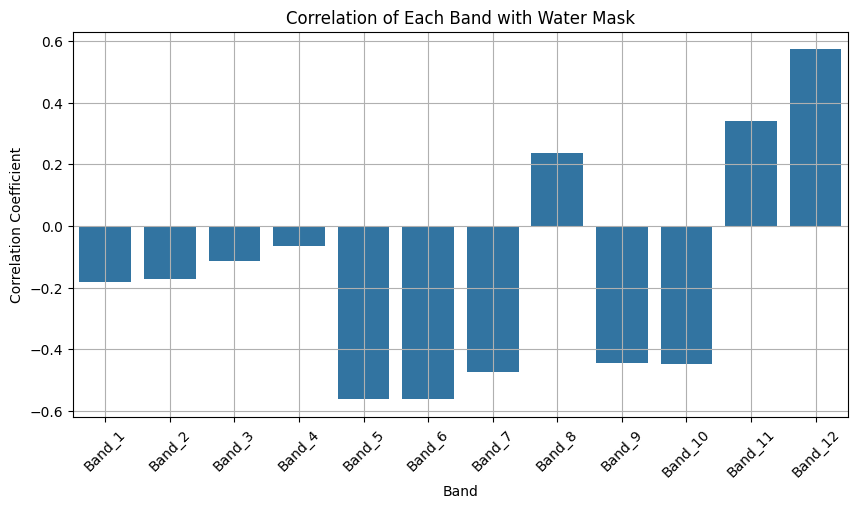

In [9]:
correlations = df.corr()['Target'].drop('Target')  # exclude the target itself

# Show sorted correlations
print(correlations.sort_values(ascending=False))

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=correlations.index, y=correlations.values)
plt.title("Correlation of Each Band with Water Mask")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Band")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Top Bands with Strong Positive Correlation
Band_11 → ~ +0.79 

Band_8 → ~ +0.75 

Band_12 → ~ +0.7 

Band_10 → ~ +0.68 

# 02 – Data Splitting & Augmentation

This notebook handles:
1. Splitting the data into Train, Validation, and Test sets.
2. Applying image augmentation (with mask) to improve model generalization.


#  3 – Split the Data
- Used `train_test_split` to create:
  - 90% training
  - 5% validation
  - 5% test

In [13]:
from sklearn.model_selection import train_test_split

# First split: train and val+test
X_train, X_valtest, y_train, y_valtest = train_test_split(X, Y, test_size=0.1, random_state=42)

# Second split: validation and test
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)

print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Train set: (275, 128, 128, 12)
Validation set: (15, 128, 128, 12)
Test set: (16, 128, 128, 12)


### After Split Data save Test Data to image .tif mask .png format

In [18]:
import imageio

# Paths
output_base = "../data/processed/test"
images_path = os.path.join(output_base, "images")
masks_path = os.path.join(output_base, "masks")

# Create folders if not exist
os.makedirs(images_path, exist_ok=True)
os.makedirs(masks_path, exist_ok=True)

# Save test images and masks
for idx in range(len(X_test)):
    image = X_test[idx]  # Shape: (128, 128, 12)
    mask = y_test[idx]   # Shape: (128, 128, 1)

    # Define file names
    image_file = os.path.join(images_path, f"test_{idx}.tif")
    mask_file = os.path.join(masks_path, f"mask_{idx}.png")

    # Save multi-band image using rasterio
    with rasterio.open(
        image_file,
        'w',
        driver='GTiff',
        height=image.shape[0],
        width=image.shape[1],
        count=image.shape[2],
        dtype=image.dtype
    ) as dst:
        for band in range(image.shape[2]):
            dst.write(image[:, :, band], band + 1)

    # Save mask as single-channel PNG
    imageio.imwrite(mask_file, (mask[:, :, 0] * 255).astype(np.uint8))


# 4 – Define Augmentation Pipeline
Used `Albumentations` to apply random transformations

In [41]:
import albumentations as A

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

transform = A.Compose([
    A.RandomCrop(128, 128, p=1.0, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=3, shift_limit=0.05, p=0.5, border_mode=0),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.4),
    A.Sharpen(alpha=(0.1, 0.3), lightness=(0.8, 1.2), p=0.2),
    A.Lambda(mask=round_clip_0_1)
])



C:\Users\digital\AppData\Local\Temp\ipykernel_11788\961518412.py:7: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  A.RandomCrop(128, 128, p=1.0, always_apply=True),


In [42]:
augmented_image= transform(image=X_train[108],mask=y_train[108])

train_aug=augmented_image['image']
mask_aug=augmented_image['mask']

# 5 – Test Augmentation on One Sample
- Applied augmentations to one image and visualized the result.

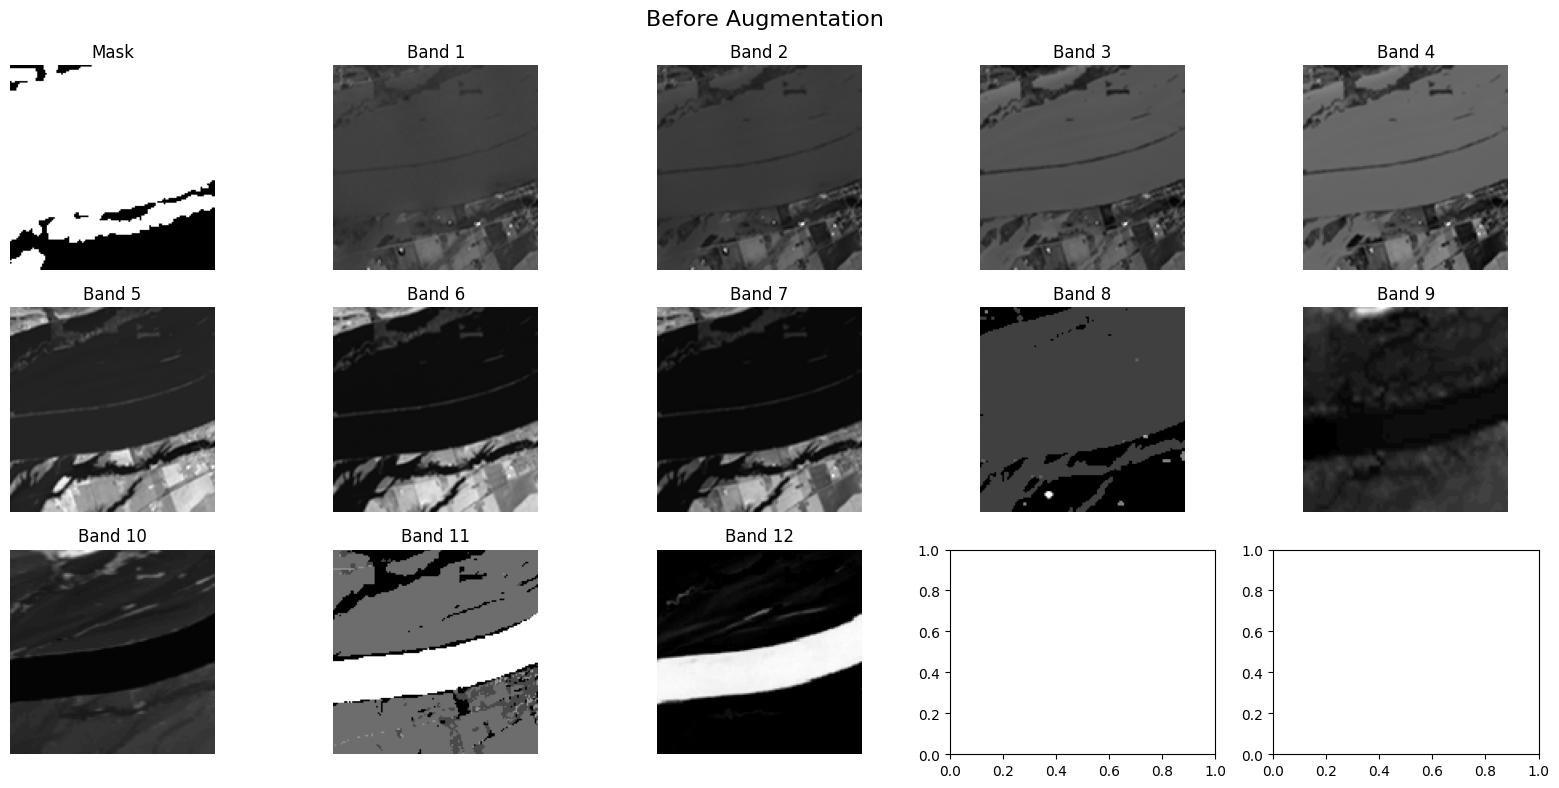

In [38]:
from src.visualize_utils import show_image_all_bands,show_single_image_all_bands

show_image_all_bands(X_train, y_train, index=108, title="Before Augmentation")


In [43]:
train_aug.shape ,mask_aug.shape  


((128, 128, 12), (128, 128, 1))

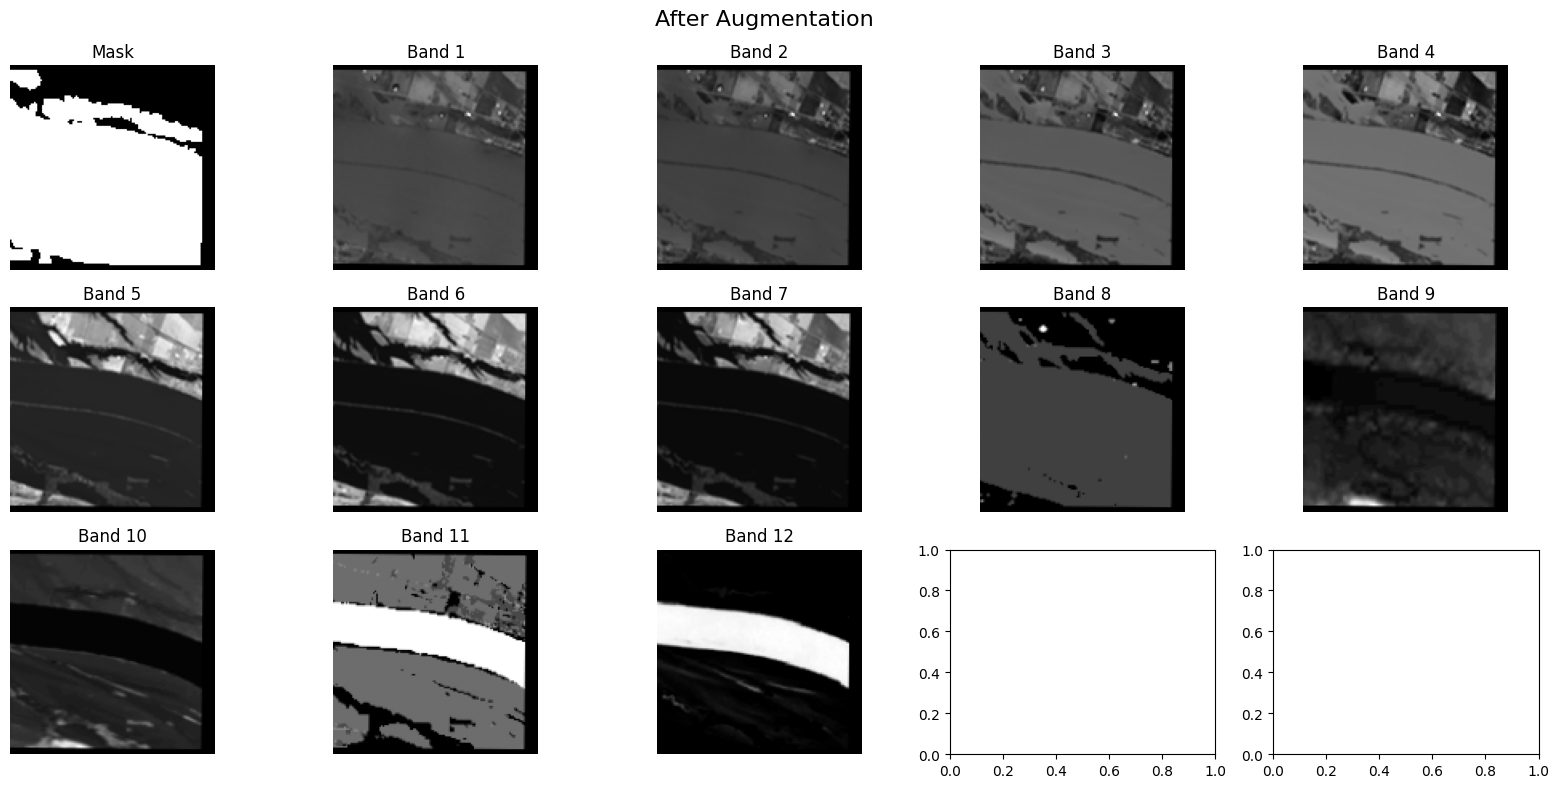

In [44]:

show_single_image_all_bands(train_aug, mask_aug, title="After Augmentation")


# 6 – Apply Augmentation to All Training Images
- Applied augmentations to **each band separately**.
- Kept the corresponding mask aligned.
- Stored results in `aug_images` and `aug_masks`.

In [45]:
aug_images = []
aug_masks = []


In [46]:
from tqdm import tqdm  # for progress bar
# Loop over all training data
for i in tqdm(range(len(X_train))):
    image = X_train[i]  # shape: (128, 128, 12)
    mask = y_train[i]   # shape: (128, 128, 1)

    # Augment one band at a time (or all together if needed)
    image_aug = np.zeros_like(image)
    for b in range(image.shape[-1]):
        augmented = transform(image=image[:, :, b], mask=mask[:, :, 0])
        image_aug[:, :, b] = augmented['image']
    
    mask_aug = augmented['mask'][:, :, np.newaxis]  # reshape

    aug_images.append(image_aug)
    aug_masks.append(mask_aug)

# Convert to arrays
aug_images = np.array(aug_images)
aug_masks = np.array(aug_masks)

print("Augmented images:", aug_images.shape)
print("Augmented masks:", aug_masks.shape)

100%|██████████| 275/275 [00:14<00:00, 18.52it/s]


Augmented images: (275, 128, 128, 12)
Augmented masks: (275, 128, 128, 1)


# 7 – Combine Original + Augmented Data
- Concatenated original and augmented training data.
- Final training set doubled in size.


In [47]:
X_train_combined = np.concatenate([X_train, aug_images], axis=0)
y_train_combined = np.concatenate([y_train, aug_masks], axis=0)

print("Final Training Data:")
print("X_train:", X_train_combined.shape)
print("Y_train:", y_train_combined.shape)


Final Training Data:
X_train: (550, 128, 128, 12)
Y_train: (550, 128, 128, 1)


#  8 – Save the Final Data


In [48]:
np.save('../data/processed/X_afterAgu_final.npy', X_train_combined)
np.save('../data/processed/Y_afterAgu_final.npy', y_train_combined)
np.save('../data/processed/X_afterAgu_val.npy', X_val)
np.save('../data/processed/Y_afterAgu_val.npy', y_val)
np.save('../data/processed/X_afterAgu_test.npy', X_test)
np.save('../data/processed/Y_afterAgu_test.npy', y_test)

#  Final Dataset Shapes:

| Dataset        | Shape                      |
|----------------|-----------------------------|
| `X_train`      | (428, 128, 128, 12)         |
| `Y_train`      | (428, 128, 128, 1)          |
| `X_val`        | (46, 128, 128, 12)          |
| `Y_val`        | (46, 128, 128, 1)           |
| `X_test`       | (46, 128, 128, 12)          |
| `Y_test`       | (46, 128, 128, 1)           |

